In [1]:
from itertools import product

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

import tensorflow_datasets as tfds

from src.models.layers import ECHConv2D, BCHConv2DComplex, conv2d_transpose

np.set_printoptions(precision=2, linewidth=150)


In [2]:
IMAGE_SHAPE = (129, 129)


In [3]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)


In [4]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask


@tf.function
def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], IMAGE_SHAPE)
    input_mask = tf.image.resize(datapoint['segmentation_mask'], IMAGE_SHAPE)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask


def random_rotate_image(image, label):
    # rotation = np.random.uniform(-180,180)
    rotation =45 
    image = rotate(image, rotation, reshape=False, order=3)
    label = rotate(label, rotation, reshape=False, order=1)
    return image, label, rotation


def tf_random_rotate_image(image, label):
    im_shape = image.shape
    label_shape = label.shape
    [
        image, label, rotation
    ] = tf.py_function(
        random_rotate_image,
        [image, label],
        [tf.float32, tf.float32, tf.float32],
    )
    image.set_shape(im_shape)
    label.set_shape(label_shape)
    return image, label, rotation


In [5]:
train = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image)

train_rotated = train.map(tf_random_rotate_image, num_parallel_calls=tf.data.AUTOTUNE)
test_rotated = test.map(tf_random_rotate_image)

In [6]:
train_dataset = train.batch(64)
test_dataset = test.batch(64)

train_dataset_rotated = train_rotated.batch(64)
test_dataset_rotated = test_rotated.batch(64)

In [7]:
sample_batch, sample_batch_mask = next(train_dataset.as_numpy_iterator())
sample_batch_rotated, sample_batch_mask_rotated, rotation = next(train_dataset_rotated.as_numpy_iterator())

In [8]:
rotation

array([45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45.,
       45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45.,
       45., 45., 45., 45., 45., 45., 45., 45.], dtype=float32)

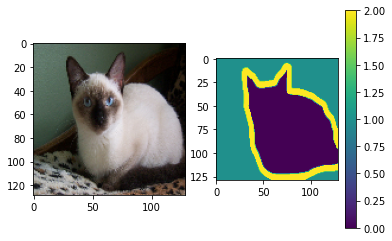

In [9]:
plt.subplot(121)
plt.imshow(sample_batch[3,:,:,:])
plt.subplot(122)
plt.imshow(sample_batch_mask[3,:,:,:])
plt.colorbar()

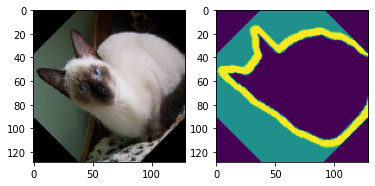

In [10]:
plt.subplot(121)
plt.imshow(sample_batch_rotated[3,:,:,:])
plt.subplot(122)
plt.imshow(sample_batch_mask_rotated[3,:,:,:])

In [11]:
np.max(sample_batch_rotated)

1.1858025

In [12]:
# layer = BCHConv2DComplex(1, 7, initializer=tf.keras.initializers.Constant(1.0), radial_profile_type="complete_radial")
layer = ECHConv2D(
    1,
    7,
    strides=2,
    initializer=tf.keras.initializers.Constant(1.0),
    is_transpose=True
)


In [13]:
atoms0, atoms = layer.conv_ch.atoms

In [14]:
atoms.shape

(7, 7, 1, 1, 4, 7)

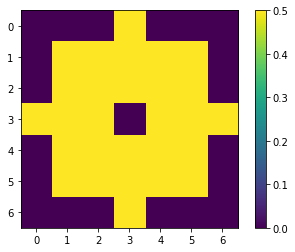

In [15]:
plt.imshow(np.real(np.sum(atoms, axis=-1)[:,:,0,0,0]))
plt.colorbar()

In [16]:
y = layer(sample_batch)
y_rotated = layer(sample_batch_rotated)

In [17]:
y.shape

TensorShape([64, 263, 263, 4])

In [18]:
radius = 263 // 2
x_grid = np.arange(-radius, radius+1 , 1)
x_coord, y_coord = np.meshgrid(x_grid, x_grid)
r = np.sqrt(x_coord**2 + y_coord**2)
mask = (r < radius-1)


In [19]:
b = 2
c_out = 0
f = np.real

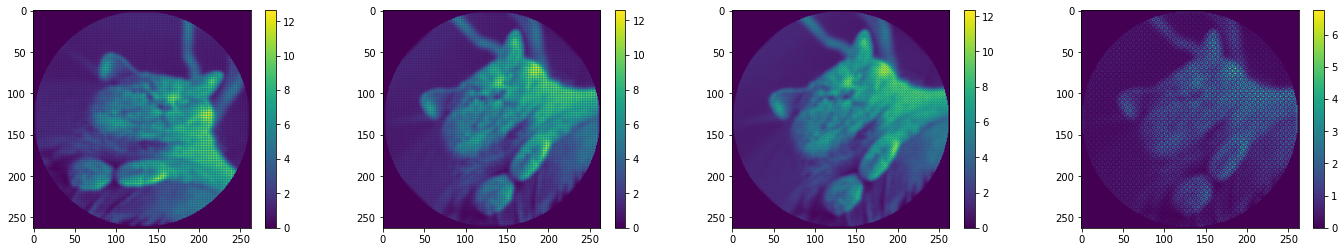

In [20]:
plt.figure(figsize=(24, 4))
plt.subplot(141)
plt.imshow(f(y.numpy()[b, :, :, c_out]) * mask)
plt.colorbar()
plt.subplot(142)
plt.imshow(f(y_rotated.numpy()[b, :, :, c_out]) * mask)
plt.colorbar()
plt.subplot(143)
feature_map_rotated = rotate(f(y.numpy()[b, :, :, c_out]),
                             rotation[b],
                             order=3,
                             reshape=False)
y_diff = f(y_rotated.numpy()[b, :, :, c_out]) - feature_map_rotated
plt.imshow(feature_map_rotated * mask)
plt.colorbar()
plt.subplot(144)
plt.imshow(np.abs(f(y_diff) * mask))
plt.colorbar()

In [ ]:
indice = np.where(f(y_diff) == np.max(f(y_diff)))
y_r = y_rotated.numpy()[b, :, :, c_out]
y_r[indice]


In [ ]:
feature_map_rotated[indice]

In [ ]:
plt.imshow(sample_batch[b,...])

In [ ]:
filters = np.squeeze(layer.conv_ch.filters.numpy())
np.real(filters[:,:,0,2])



In [ ]:
filters = np.array([[0,1,0], [1,0,1], [0,1,0]])
filters = np.stack(3*[filters], axis=-1)
filters = filters[..., np.newaxis]

In [ ]:
filters = tf.constant(filters, dtype=tf.float32)

In [ ]:
image = sample_batch[:4,...]

In [ ]:
# output = tf.nn.conv2d_transpose(image, filters)
conv_transpose = tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding="SAME")

In [ ]:
a,b,c,d = tf.shape(filters)

In [ ]:
output_trans = conv2d_transpose(image, filters, 1).numpy()
output = tf.nn.conv2d(image, filters, 1, "SAME").numpy()
# output = conv_transpose(image)

In [ ]:
output.shape

In [ ]:
output_trans.shape

In [ ]:
plt.figure(figsize=(24, 4))
plt.subplot(131)
plt.imshow(output_trans[0,...])
plt.colorbar()
plt.subplot(132)
plt.imshow(output[0,...])
plt.colorbar()
plt.subplot(133)
plt.imshow(np.abs(output-output_trans)[0,...])
plt.colorbar()